# Mask R-CNN - Train on Simple Baby Dataset

Modification of the Shapes Training sample.

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
session = tf.compat.v1.Session(config=config)

In [3]:
class BabiesConfig(Config):
    """Configuration for training on the babies dataset.
    Derives from the base Config class and overrides values specific
    to the babies dataset.
    """
    # Give the configuration a recognizable name
    NAME = "babies"
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 28

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = BabiesConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                   

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class BabiesDataset(utils.Dataset):
    """Generates the babies dataset.
    """

    def load_babies(self, count, validation=False):
        """Generate the requested number of images.
        count: number of images to generate.
        validation: whether this is validation set.
        """
        # Add classes
        self.add_class("babies", 1, "baby")
        
        image_dir = 'Images'
        if validation:
            image_dir = os.path.join(image_dir, 'Validation')
        else:
            image_dir = os.path.join(image_dir, 'Training')

        # Add images
        for i in range(count):
            image_path = os.path.join(image_dir, '{}.png'.format(i))
            image = skimage.io.imread(image_path)
            self.add_image("babies", image_id=i, path=image_path,
                           height=image.shape[0], width=image.shape[1])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        elif info["source"] == "babies":
            return info
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        image_path = info['path']
        validation_path = image_path.replace('.png', '.labels.tif')
        mask = skimage.io.imread(validation_path)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        class_ids = np.array([1], np.int32)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [6]:
# Training dataset
dataset_train = BabiesDataset()
dataset_train.load_babies(28)
dataset_train.prepare()

# Validation dataset
dataset_val = BabiesDataset()
dataset_val.load_babies(5, validation=True)
dataset_val.prepare()

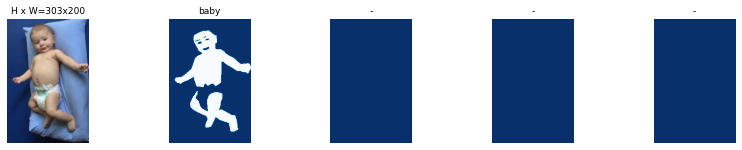

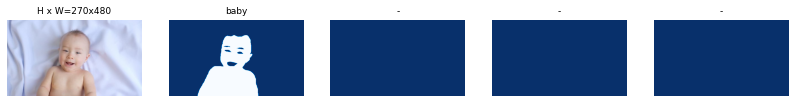

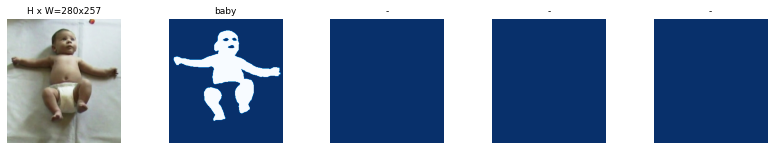

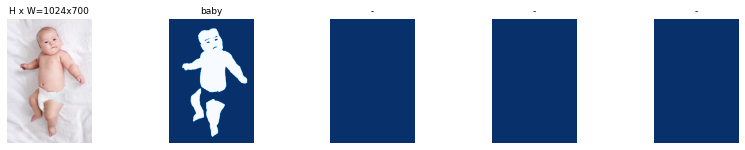

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\nicho\MaskR\Mask_RCNN\logs\babies20210209T0726\mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_d

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

 1/28 [>.............................] - ETA: 3:42 - batch: 0.0000e+00 - size: 1.0000 - loss: 2.5759 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 0.6352 - mrcnn_class_loss: 0.6010 - mrcnn_bbox_loss: 0.6384 - mrcnn_mask_loss: 0.6423

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/28 [==>...........................] - ETA: 14s - batch: 1.0000 - size: 1.0000 - loss: 2.7959 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.7110 - mrcnn_class_loss: 0.4788 - mrcnn_bbox_loss: 0.8757 - mrcnn_mask_loss: 0.6713    

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/28 [====>.........................] - ETA: 8s - batch: 2.0000 - size: 1.0000 - loss: 2.7822 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.8597 - mrcnn_class_loss: 0.3685 - mrcnn_bbox_loss: 0.8656 - mrcnn_mask_loss: 0.6294 

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/28 [=====>........................] - ETA: 8s - batch: 2.5000 - size: 1.0000 - loss: 2.5985 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 0.7851 - mrcnn_class_loss: 0.3279 - mrcnn_bbox_loss: 0.8190 - mrcnn_mask_loss: 0.6084

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/28 [======>.......................] - ETA: 7s - batch: 3.0000 - size: 1.0000 - loss: 2.6416 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.8122 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.8826 - mrcnn_mask_loss: 0.5867

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/28 [========>.....................] - ETA: 5s - batch: 4.0000 - size: 1.0000 - loss: 2.5988 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 0.7384 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.9802 - mrcnn_mask_loss: 0.5765

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/28 [==========>...................] - ETA: 4s - batch: 5.0000 - size: 1.0000 - loss: 2.4222 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.9017 - mrcnn_mask_loss: 0.5504

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/28 [===========>..................] - ETA: 4s - batch: 5.5000 - size: 1.0000 - loss: 2.3014 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 0.7253 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.8266 - mrcnn_mask_loss: 0.5046

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/28 [==============>...............] - ETA: 3s - batch: 6.5000 - size: 1.0000 - loss: 2.3112 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.6883 - mrcnn_class_loss: 0.1735 - mrcnn_bbox_loss: 0.8881 - mrcnn_mask_loss: 0.5120

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/28 [===============>..............] - ETA: 3s - batch: 7.0000 - size: 1.0000 - loss: 2.2642 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.6572 - mrcnn_class_loss: 0.1620 - mrcnn_bbox_loss: 0.8939 - mrcnn_mask_loss: 0.5032

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/28 [=================>............] - ETA: 2s - batch: 8.0000 - size: 1.0000 - loss: 2.2242 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.6383 - mrcnn_class_loss: 0.1497 - mrcnn_bbox_loss: 0.8954 - mrcnn_mask_loss: 0.4963

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/28 [==================>...........] - ETA: 2s - batch: 8.5000 - size: 1.0000 - loss: 2.1629 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.6126 - mrcnn_class_loss: 0.1419 - mrcnn_bbox_loss: 0.8781 - mrcnn_mask_loss: 0.4865

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/28 [====================>.........] - ETA: 1s - batch: 9.5000 - size: 1.0000 - loss: 2.1242 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.5982 - mrcnn_class_loss: 0.1321 - mrcnn_bbox_loss: 0.8774 - mrcnn_mask_loss: 0.4745

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


22/28 [======================>.......] - ETA: 1s - batch: 10.5000 - size: 1.0000 - loss: 2.0822 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.5832 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.8719 - mrcnn_mask_loss: 0.4641

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


24/28 [========================>.....] - ETA: 0s - batch: 11.5000 - size: 1.0000 - loss: 2.0348 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.5642 - mrcnn_class_loss: 0.1139 - mrcnn_bbox_loss: 0.8611 - mrcnn_mask_loss: 0.4568

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


26/28 [==========================>...] - ETA: 0s - batch: 12.5000 - size: 1.0000 - loss: 1.9922 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.5466 - mrcnn_class_loss: 0.1076 - mrcnn_bbox_loss: 0.8507 - mrcnn_mask_loss: 0.4487

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


28/28 [==============================] - ETA: 0s - batch: 13.5000 - size: 1.0000 - loss: 1.9476 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.5304 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.8350 - mrcnn_mask_loss: 0.4426

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in Te

28/28 [==============================] - 22s 493ms/step - batch: 13.5000 - size: 1.0000 - loss: 1.9476 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.5304 - mrcnn_class_loss: 0.1017 - mrcnn_bbox_loss: 0.8350 - mrcnn_mask_loss: 0.4426 - val_loss: 2.0068 - val_rpn_class_loss: 0.0367 - val_rpn_bbox_loss: 0.5515 - val_mrcnn_class_loss: 0.0336 - val_mrcnn_bbox_loss: 1.0188 - val_mrcnn_mask_loss: 0.3662


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\nicho\MaskR\Mask_RCNN\logs\babies20210209T0726\mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_2/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a lar

 1/28 [>.............................] - ETA: 3:55 - batch: 0.0000e+00 - size: 1.0000 - loss: 2.1530 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.6512 - mrcnn_mask_loss: 0.2976

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/28 [=>............................] - ETA: 34s - batch: 0.5000 - size: 1.0000 - loss: 2.8714 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.7758 - mrcnn_mask_loss: 0.3603     

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/28 [==>...........................] - ETA: 19s - batch: 1.0000 - size: 1.0000 - loss: 2.5196 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1597 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.6848 - mrcnn_mask_loss: 0.3358

c:\users\nicho\miniconda3\envs\fyp\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(BabiesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))